# Homework #8 --The Last One-- (100 pts)
**Due:** Thursday March 8th, 11:59PM via Blackboard.  

**Name:** **Anish Doshi**,  **Student Id:** **ap2326**

In this homework we will review a bit about traffic engineering, and start learning about delays (queues) in networks and how to simulate them.

In [5]:
# The following enables embedded ploting via matplot lib.
%matplotlib notebook
import matplotlib.pyplot as plt
from SimComponents import PacketGenerator, PacketSink, FlowDemux, ShaperTokenBucket, TrTCM
import simpy

## Problem 1. Simulation General (20 pts)

**(a)** Give four place where we might want to use random numbers (random variables with a particular distribution) in our network simulations?

**Ans.** Random numbers usage in our network simulations: (i)time arrivals between packets (ii)size for packets (iii)modelling of packet routes (iv)network queue (v)random routing/branching

**(b)** What is the difference between network *emulation* (like what is done in Mininet) and the network *simulations* we are now doing?

**Ans.** Emulation is testing the network whereas simulation is moedeling of the enviournment. Emulation is full of detail as if real system whereas simulation is just an instance or similar to actual. To elaborate with example, emulation is actual packet and simulation is just header with field data.

**(c)** How could you make our simulations more useful to model *Differentiated Services* in an IP network? How might you change the *Packet* class in the `SimComponents.py` file?

**Ans.** By adding the priority field in the packet model we can make our simulations more useful to model *Differentiated Services* in an IP network. We can change the *Packet* class in the `SimComponents.py` file by these packets and timestamp fields.

**(d)** List two ways to try and verify if a simulation you have run reflects reality?

**Ans.** One of the way is we can perform theoritical calculations and then compare the results with graph plot by code. Other ways are Operational Validity check,  Hypothesis check etc.  



## Problem 2. Traffic Shaping
Note in this problem and many of our traffic shapping examples we use constant sized packets. This is only to make the results easy to interpret on a plot of arrival times and is **not** required for correct operation of a traffic shaper or policer.  See the `ShaperExample2.py` file included with the homework for setup and plotting.

**(a)** Create a source that sends 200 byte packets in the following way. Three packets in a consecutively  with 2 usec spacing followed by two packets with 5 usec spacing.  Show a line plot of the packet sending times showing two to three repetitions of this sending pattern.

**(b)** What is the average rate in bits per second for this source?

**(c)** Compare (plot) the output times of the packets from the source you created about to that same source run through a Token Bucket traffic shaper with a bucket size of 300 bytes and a rate equal to what you calculated in part (b).



In [6]:
#Part(2a)

def mypattern():
    while True:
        yield 2
        yield 2
        yield 2
        yield 5
        yield 5
        

In [7]:
mygen = mypattern()
for i in range(15):
    print(next(mygen))

2
2
2
5
5
2
2
2
5
5
2
2
2
5
5


In [8]:
#Part(2b)

num_packets = 5
size_packet = 200
totaltime = 16 
average = (num_packets*size_packet*8)/totaltime
print(f"The average rate in bits per second for this source is {average} Mbps")

The average rate in bits per second for this source is 500.0 Mbps


Packet Sink arrivals are : [2.0, 4.0, 6.0, 11.0, 16.0, 18.0, 20.0, 22.0, 27.0, 32.0, 34.0, 36.0, 38.0, 43.0, 48.0, 50.0, 52.0, 54.0, 59.0, 64.0]


<IPython.core.display.Javascript object>


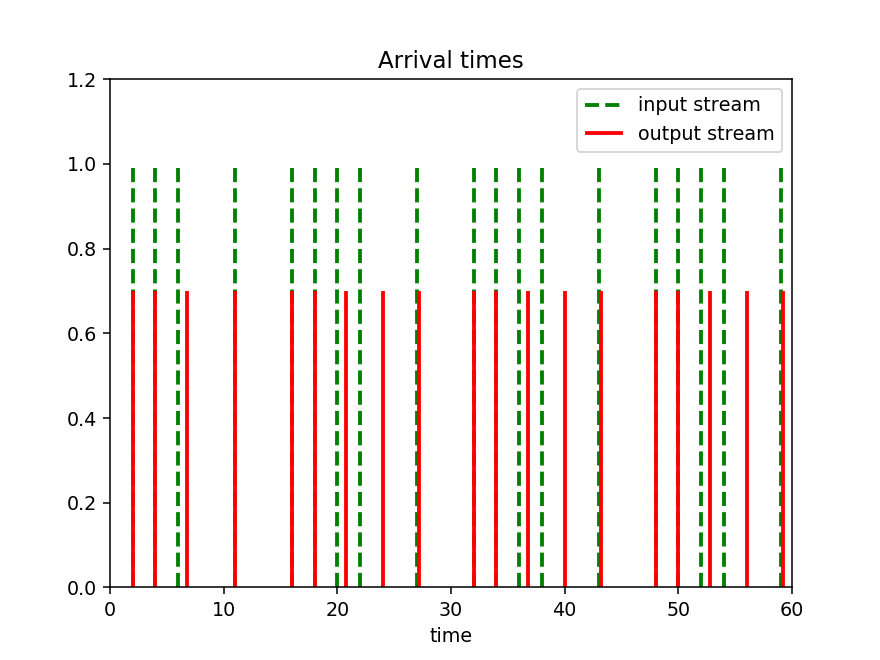

In [35]:
#Part(2c)

"""
This file shows an example of a traffic shaper whose bucket size is
a multiple of the packet size and whose bucket rate is very slow compared
to the input.

Copyright Dr. Greg M. Bernstein 2014
Released under the MIT license
"""
import simpy
import matplotlib.pyplot as plt

from SimComponents import PacketGenerator, PacketSink, ShaperTokenBucket


import simpy
import matplotlib.pyplot as plt
from SimComponents import PacketGenerator, PacketSink, ShaperTokenBucket

# You need to create the pattern "generator"
mygen = mypattern()
mygen2 = mypattern()

def arrivals1():
    return next(mygen)

def arrivals2():
    return next(mygen2)

def const_size():
    return 200.0

env = simpy.Environment()
# Create two identical packet generators based on your pattern
# one will go through a shaper and one will not
pg = PacketGenerator(env, "CSU", arrivals1, const_size, initial_delay=0.0, finish=60)
pg2 = PacketGenerator(env, "EB", arrivals2, const_size, initial_delay=0.0, finish=60)

# Two packet sinks to measure the arrival times
ps = PacketSink(env, rec_arrivals=True, absolute_arrivals=True)
ps2 = PacketSink(env, rec_arrivals=True, absolute_arrivals=True)

bucket_rate = 500
bucket_size = 300
shaper = ShaperTokenBucket(env, bucket_rate, bucket_size)
pg.out = ps
pg2.out = shaper
shaper.out = ps2
env.run(until=10000)
print(f"Packet Sink arrivals are : {ps.arrivals}")

fig, axis = plt.subplots()
axis.vlines(ps.arrivals, 0.0, 1.0, colors="g", linewidth=2.0, linestyles='--', label='input stream')
axis.vlines(ps2.arrivals, 0.0, 0.7, colors="r", linewidth=2.0, label='output stream')
axis.set_title("Arrival times")
axis.set_xlabel("time")
axis.set_ylim([0, 1.2])
axis.set_xlim([0, 60])
axis.legend()
plt.show()

## Problem 3. Scheduling and Fairness

**(a)** In the figure shown below show the ordering of the packets as they leave the system assuming (i)priority scheduling (with #1 having the highest priority), and (ii) Round Robin scheduling.
![Packet Scheduling](schedule.png)

**(b)** In *Stochastic Fair Queueing* what header fields can we hash on and which shouldn't we hash on to avoid packet reordering problems with TCP connections?

**(c)** How does Linux's implementation of [SFQ](http://manpages.ubuntu.com/manpages/artful/man8/tc-sfq.8.html) prevent an unlucky users getting stuck in the same hash based queue forever?


**#Part(3a)Ans.**

Ordering of the packets as they leave the system in: (i) priority scheduling: AAA BBB CCCCCC (ii)Round Robin scheduling[assuming 1 frame per delta time]: ABC ABC ABC C C C 

**#Part(3b)Ans.**

In SFQ header fields we can hash are: source & destination TCP addresses and port numbers

In SFQ header fields we should not hash are: pointers


**#Part(3c)Ans.**

In Linux's implementation for SFQ, it uses source & destination IP addresses and port numbers of TCP and/or UDP to prevent users getting into hash based queue forever. Also, it uses changing of the hash function, empty all the queues and start over.

## Problem 4. Policing, Metering and Marking

For a Two rate three color marker (policer) with a Peak Information Rate (PIR) of 6Gbps, a Peak Burst Size (PBS) of 3000 bytes, a Committed Information Rate (CIR) of 3Gbps, and a Committed Burst Size (CBS) of 4000 bytes answer the following questions. You may want to use the code below in this notebook.

**(a)** If the source has a constant packet size of 1500 bytes, what is the range of interarrival times that will guarantee that all packets will be marked Green? Demonstrate this with the shortest permitted time.

**(b)** If the source has a constant packet size of 1500 bytes, what is the range of interarrival times that will guarantee that all packets will be marked Green and Yellow but no Red? Demonstrate this with the mid point of the time range.

**(c)** Above what rate (below what interarrival time) will some packets be marked red? Demonstrate this with a value twice the rate (half the time).


In [32]:
#Part4:

greenrate = 3000.0/(1500*8)
redrate = 6000.0/(1500*8)
print(f"Greeen Rate: {greenrate} and Green Time: {1/greenrate}")
print(f"Red Rate: {redrate} and Red Time: {1/redrate}")

Greeen Rate: 0.25 and Green Time: 4.0
Red Rate: 0.5 and Red Time: 2.0


<IPython.core.display.Javascript object>


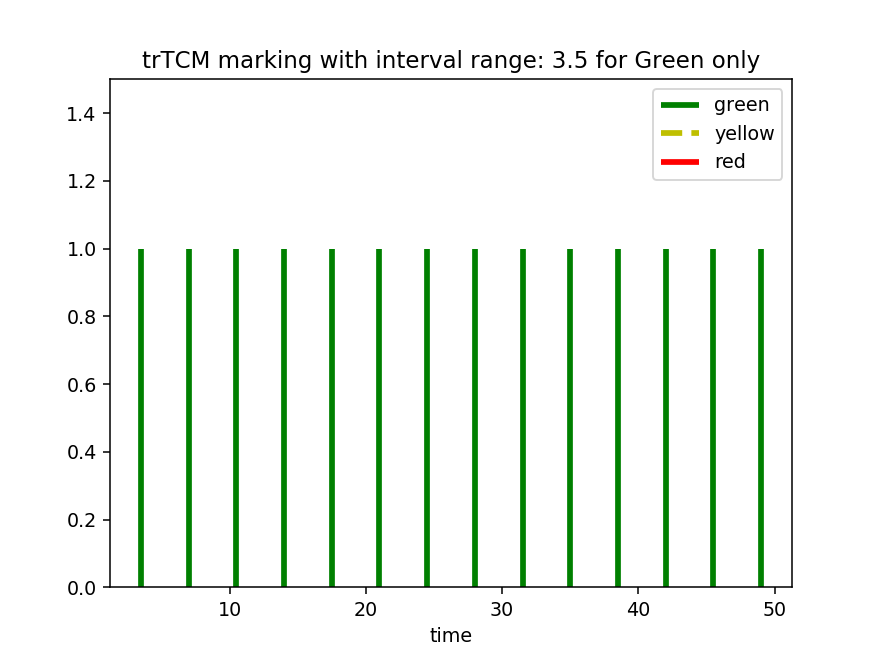

In [33]:
#Part(4a)Only Green

def const_arrival():
    return 3.5  # Change value here

def const_size():
    return 1500.0

pir = 6000.0  # 6Gbps
pbs = 3000  # bytes
cir = 3000.0  # 3Gbps
cbs = 4000  # bytes

env = simpy.Environment()
pg = PacketGenerator(env, "B&M", const_arrival, const_size)
ps_green = PacketSink(env, rec_arrivals=True, absolute_arrivals=True)
ps_yellow = PacketSink(env, rec_arrivals=True, absolute_arrivals=True)
ps_red = PacketSink(env, rec_arrivals=True, absolute_arrivals=True)
marker = TrTCM(env, pir, pbs, cir, cbs)
demux = FlowDemux([ps_green, ps_yellow, ps_red])
pg.out = marker
marker.out = demux
env.run(until=50)

fig, ax1 = plt.subplots()
ax1.vlines(ps_green.arrivals, 0.0, 1.0, colors="g", linewidth=3.0, label='green')
ax1.vlines(ps_yellow.arrivals, 0.0, 0.8, colors="y", linewidth=3.0, linestyles='--', label='yellow')
ax1.vlines(ps_red.arrivals, 0.0, 0.6, colors="r", linewidth=3.0, label='red')
ax1.set_title("trTCM marking with interval range: 3.5 for Green only")
ax1.set_xlabel("time")
ax1.set_ylim([0, 1.5])
ax1.legend()
plt.show()

<IPython.core.display.Javascript object>


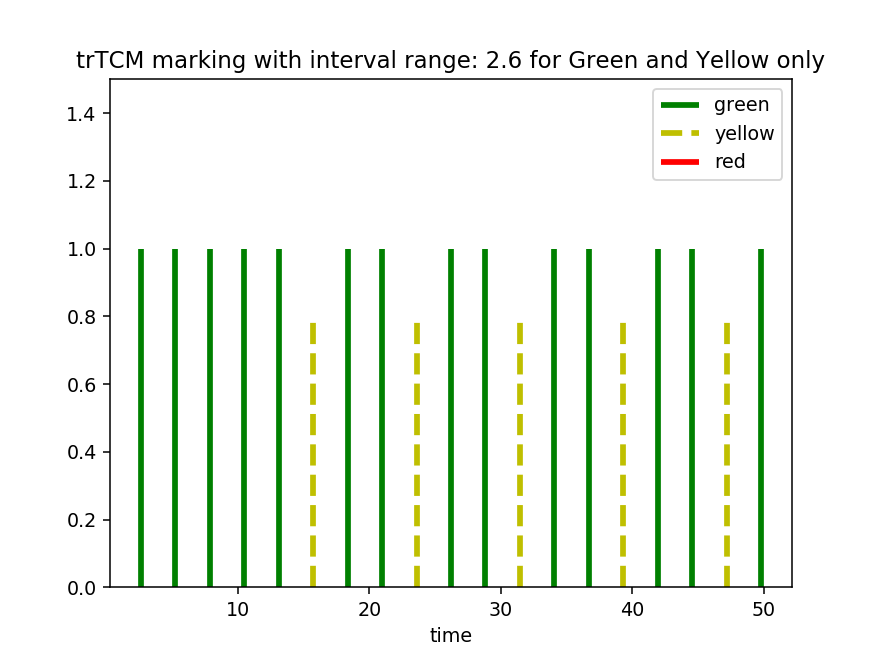

In [31]:
#Part(4b)Only Green & Yellow 

def const_arrival():
    return 2.62  # the mid point of the time range

def const_size():
    return 1500.0

pir = 6000.0  # 6Gbps
pbs = 3000  # bytes
cir = 3000.0  # 3Gbps
cbs = 4000  # bytes

env = simpy.Environment()
pg = PacketGenerator(env, "B&M", const_arrival, const_size)
ps_green = PacketSink(env, rec_arrivals=True, absolute_arrivals=True)
ps_yellow = PacketSink(env, rec_arrivals=True, absolute_arrivals=True)
ps_red = PacketSink(env, rec_arrivals=True, absolute_arrivals=True)
marker = TrTCM(env, pir, pbs, cir, cbs)
demux = FlowDemux([ps_green, ps_yellow, ps_red])
pg.out = marker
marker.out = demux
env.run(until=50)

fig, ax1 = plt.subplots()
ax1.vlines(ps_green.arrivals, 0.0, 1.0, colors="g", linewidth=3.0, label='green')
ax1.vlines(ps_yellow.arrivals, 0.0, 0.8, colors="y", linewidth=3.0, linestyles='--', label='yellow')
ax1.vlines(ps_red.arrivals, 0.0, 0.6, colors="r", linewidth=3.0, label='red')
ax1.set_title("trTCM marking with interval range: 2.6 for Green and Yellow only")
ax1.set_xlabel("time")
ax1.set_ylim([0, 1.5])
ax1.legend()
plt.show()

<IPython.core.display.Javascript object>


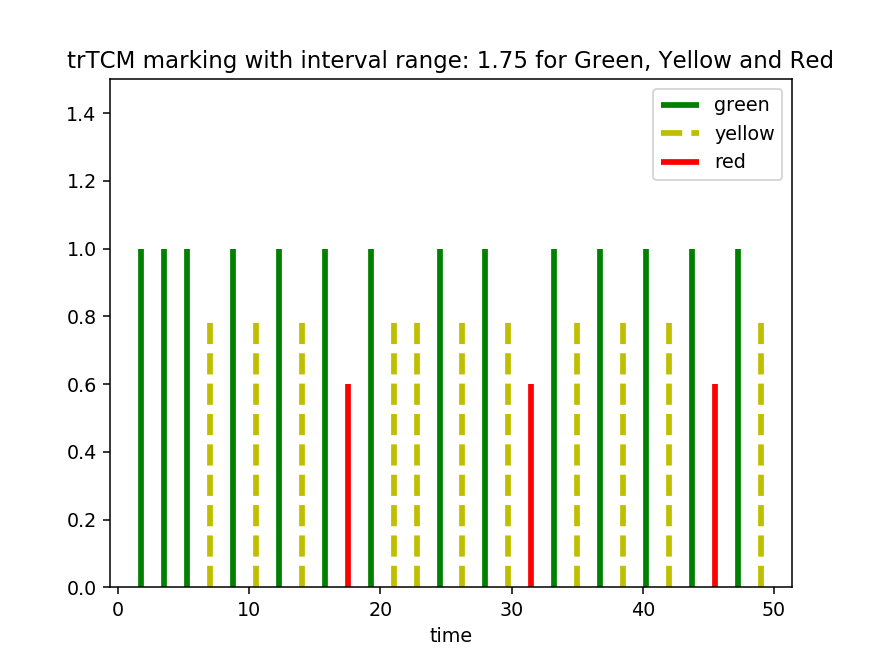

In [34]:
#Part(4c)All three: Green, Yellow and Red

def const_arrival():
    return 1.75  #  value twice the rate (half the time)

def const_size():
    return 1500.0

pir = 6000.0  # 6Gbps
pbs = 3000  # bytes
cir = 3000.0  # 3Gbps
cbs = 4000  # bytes

env = simpy.Environment()
pg = PacketGenerator(env, "B&M", const_arrival, const_size)
ps_green = PacketSink(env, rec_arrivals=True, absolute_arrivals=True)
ps_yellow = PacketSink(env, rec_arrivals=True, absolute_arrivals=True)
ps_red = PacketSink(env, rec_arrivals=True, absolute_arrivals=True)
marker = TrTCM(env, pir, pbs, cir, cbs)
demux = FlowDemux([ps_green, ps_yellow, ps_red])
pg.out = marker
marker.out = demux
env.run(until=50)

fig, ax1 = plt.subplots()
ax1.vlines(ps_green.arrivals, 0.0, 1.0, colors="g", linewidth=3.0, label='green')
ax1.vlines(ps_yellow.arrivals, 0.0, 0.8, colors="y", linewidth=3.0, linestyles='--', label='yellow')
ax1.vlines(ps_red.arrivals, 0.0, 0.6, colors="r", linewidth=3.0, label='red')
ax1.set_title("trTCM marking with interval range: 1.75 for Green, Yellow and Red")
ax1.set_xlabel("time")
ax1.set_ylim([0, 1.5])
ax1.legend()
plt.show()

## Problem 5. The Differentiated Services Model for IP

**(a)** In the Differentiated services model who is responsible (network or endpoint) for traffic shaping?
**Ans.** In the Differentiated services model *Customer* is responsible for traffic shaping?

**(b)** In the Differentiated services model who is responsible for traffic policing (network or endpoint)? Where does policing need to be done (everywhere?, selected points?) Explain.
**Ans.** In the Differentiated services model *network* is responsible for traffic policing and it is done *in the network* at selected points.

**(c)** Suppose your network switches only supported simple three level priority packet scheduling along with the ability to limit buffer sizes for each priority level. Explain, qualitatively, how you would allocate priorities and buffer limits to the following three traffic types (i) Voice over IP, (ii) video streaming services, and (iii) file transfer services (including large files).
**Ans.** Allocation for the following traffic types is in the order of highest priority and small buffer size to lowest priority and big buffer sizeL: (i)VoIP (ii)Video Streaming and (iii)Large Size File Transfer Service.
